In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import math


# Reading CSV file

In [47]:
Stock = pd.read_csv('NSE-ICICIBANK.csv', index_col='Date',parse_dates=True)
Stock.drop(['series','VALUE'], inplace=True, axis=1)
df_Stock = Stock.sort_index(ascending=True)
df_Stock

,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,No of trades
Date,,,,,,,,,,,
2019-04-24,397.10,402.65,393.45,396.50,401.60,401.10,397.78,411.0,256.50,11397163,143131
2019-04-25,400.90,402.40,394.30,401.10,395.65,395.40,398.27,411.0,256.50,16524091,116341
2019-04-26,400.00,408.00,394.25,395.40,407.20,407.20,402.32,411.0,256.50,14286163,132349
2019-04-30,407.75,409.80,403.30,407.20,405.75,407.50,407.21,411.0,256.50,19375553,226795
2019-05-02,403.70,405.00,394.40,407.50,394.75,395.55,399.85,411.0,256.50,16572948,190606
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16,574.60,577.75,564.10,575.20,565.05,566.95,569.62,679.4,285.55,24045008,259366
2021-04-19,550.00,562.30,534.40,566.95,560.40,559.75,547.46,679.4,285.55,28526176,301440
2021-04-20,565.20,572.65,552.60,559.75,558.40,559.10,562.91,679.4,285.55,24425842,265471


In [48]:
df_Stock.tail(5) #Last five row

,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,No of trades
Date,,,,,,,,,,,
2021-04-16,574.6,577.75,564.10,575.20,565.05,566.95,569.62,679.4,285.55,24045008,259366
2021-04-19,550.0,562.30,534.40,566.95,560.40,559.75,547.46,679.4,285.55,28526176,301440
2021-04-20,565.2,572.65,552.60,559.75,558.40,559.10,562.91,679.4,285.55,24425842,265471
2021-04-22,552.0,580.60,546.90,559.10,578.40,579.20,570.14,679.4,285.55,34942633,340989
2021-04-23,569.9,580.50,567.05,579.20,567.50,569.95,572.81,679.4,285.55,33749097,364665


In [49]:
df_Stock.shape #No. of columns and row

(495, 11)

In [50]:
df_Stock.columns #Name of columns

Index(['OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'ltp', 'close', 'vwap', '52W H',
       '52W L', 'VOLUME', 'No of trades '],
      dtype='object')

# Ploting Closed Price v/s Date

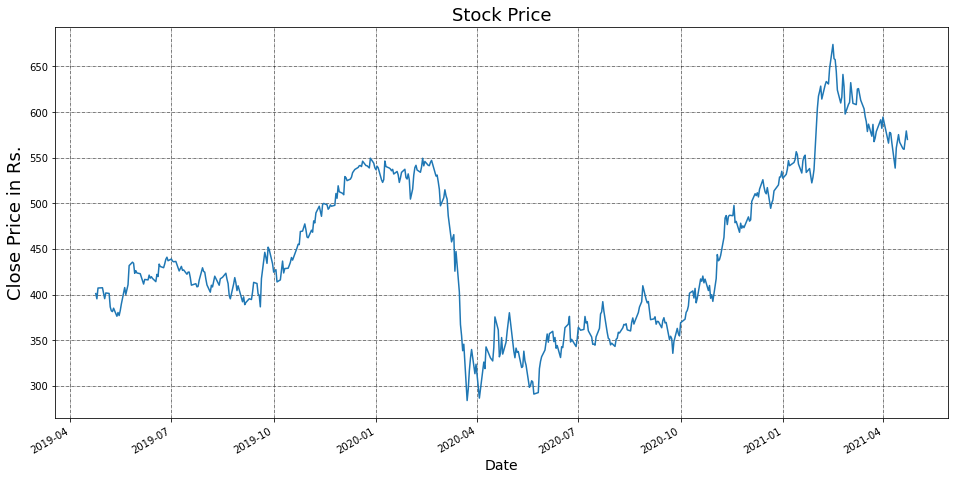

In [51]:
df_Stock['close'].plot(figsize=(16, 8))
plt.title("Stock Price", fontsize=18)
plt.ylabel('Close Price in Rs.', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

# Splitting dataset for training , validation and test sets

In [188]:
new_data = pd.DataFrame(index=range(0,len(df_Stock)),columns=['Date', 'Close'])
for i in range(0,len(df_Stock)):
    new_data['Date'][i] =i+1
    new_data['Close'][i] = df_Stock['close'][i]
    
#setting index
new_data.index = df_Stock.index
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

training_data_len = math.ceil(len(dataset) * 0.8) #80% of dateset
training_data_len

train = dataset[0:math.ceil(0.8*training_data_len),:]
valid = dataset[math.ceil(0.8*training_data_len):,:]



(178,)

# Scaling Our Dataset

In [163]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# X_train & Y_train

In [82]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# Inserting X_train & Y_train in Our model

In [84]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [85]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

257/257 - 5s - loss: 0.0101


In [141]:
#predicting 238 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
obj = scaler.fit(inputs)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


# Calculating its performance

In [142]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

33.44097459516177

In [192]:
#for plotting
train = dataset[0:math.ceil(0.8*training_data_len),:]
valid = dataset[math.ceil(0.8*training_data_len):,:]
pred_stock = pd.DataFrame(index=range(0,len(valid)),columns=['Actual', 'Predicted'])
train_stock = df_Stock.index[math.ceil(0.8*training_data_len):]
pred_stock.index = train_stock
pred_stock['Actual'] = valid
pred_stock['Predicted'] = closing_price
pred_stock

,Actual,Predicted
Date,,
2020-08-06,358.75,355.984589
2020-08-07,357.95,355.145294
2020-08-10,363.55,354.834778
2020-08-11,367.35,355.227600
2020-08-12,366.85,356.269714
...,...,...
2021-04-16,566.95,536.947266
2021-04-19,559.75,536.146545
2021-04-20,559.1,535.182434


# Plotting Actual v/s Predicted graph

<AxesSubplot:xlabel='Date'>

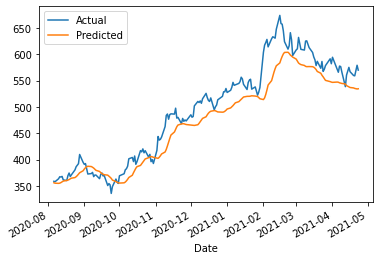

In [193]:
pred_stock[['Actual', 'Predicted']].plot()

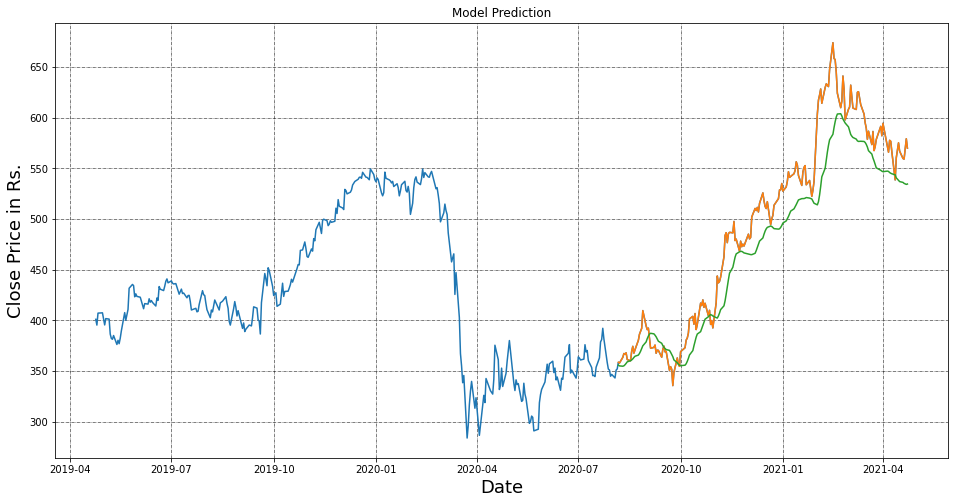

In [196]:
train = df_Stock[: df_Stock.shape[0]]
plt.figure(figsize = (16,8))
plt.title ('Model Prediction')
plt.xlabel ("Date" ,fontsize=18)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.ylabel ("Close Price in Rs." ,fontsize=18)
plt.plot(train['close'])
plt.plot(pred_stock[['Actual', 'Predicted']])
plt.show()
